## Comparison of TD(0) and First Visit MC - Part 1 (Wall Following domain)

##### Sumana Basu (260727568)

**Problem Description :**

In the context of wall following domain, performance of TD(0) and First Visit Monte Carlo has been compared.

Note that for the given policy since there is no loop, every visit MC is same as First visit MC.

**Domain : **

In the wall following domain -
* Robot starts from one of the bottom three states (as in fig.) and
* Works its way up one row at a time
* Trial terminates if -
    * robot runs into the wall
    * wanders off into the "open space"
    * successfully reaches the exit

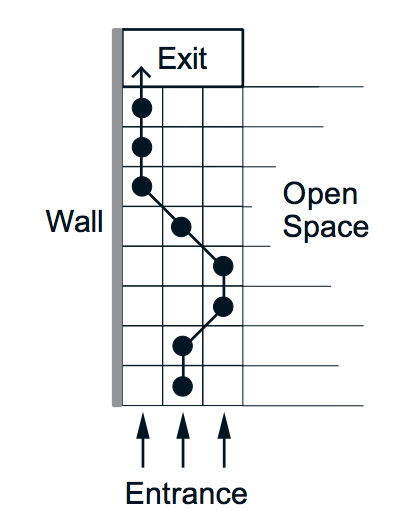

In [183]:
from IPython.display import Image
Image(filename='Sample Trajectory.png')

**States :**

The environment consists of 3x9 states.

Start States - 3 states closer to the entrance ('00','01','02') are equally likely to be start states.

Terminal States - '24','25','27' are the terminal states.

**Action :**

At any step the robot can stochastically take one of 3 actions :

* Forward Left
* Directly Forward
* Forward Right

(Probability of each action is defined below)

**Reward structure: **
    
* If the robot hits the wall or wanders off into the "open space" : 0
* If the robot reaches the exit : +1
* Everywhere else : -1

**Goal : **

To reach the exit

**Policy : **

The robot's wall-following policy tries to keep the robot in the center column, neither too close to the wall, which risks a collision, nor too far from it.

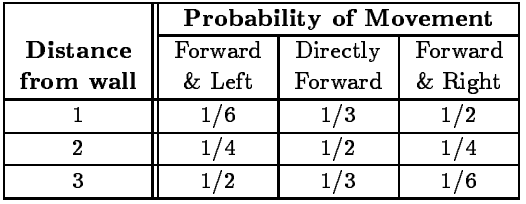

In [184]:
Image(filename='policy.png')

**Environment**

Here, I have generated 50,000 episodes following the policy mentioned above.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
NUM_EPISODES = 50000

In [3]:
#Define States
states = ['00', '01', '02',
          '03', '04', '05',
          '06', '07', '08',
          '09', '10', '11',
          '12', '13', '14',
          '15', '16', '17',
          '18', '19', '20',
          '21', '22', '23',
          '24', '25', '26',]

In [4]:
EXIT_STATES = ['24','25','26']

In [5]:
intermediate_states = [s for s in states if s not in EXIT_STATES]

In [6]:
#Define Actions
actions = ['FORWARD_LEFT', 'DIRECTLY_FORWARD', 'FORWARD_RIGHT']

FORWARD_LEFT = 'FORWARD_LEFT'
DIRECTLY_FORWARD = 'DIRECTLY_FORWARD'
FORWARD_RIGHT = 'FORWARD_RIGHT'

In [7]:
#Define state transitions
state_transitions = {
                '00' : {FORWARD_LEFT:'00', DIRECTLY_FORWARD : '03', FORWARD_RIGHT : '04'},
                '01' : {FORWARD_LEFT:'03', DIRECTLY_FORWARD : '04', FORWARD_RIGHT : '05'},
                '02' : {FORWARD_LEFT:'04', DIRECTLY_FORWARD : '05', FORWARD_RIGHT : '02'},
                '03' : {FORWARD_LEFT:'03', DIRECTLY_FORWARD : '06', FORWARD_RIGHT : '07'},   
                '04' : {FORWARD_LEFT:'06', DIRECTLY_FORWARD : '07', FORWARD_RIGHT : '08'}, 
                '05' : {FORWARD_LEFT:'07', DIRECTLY_FORWARD : '08', FORWARD_RIGHT : '05'},
                '06' : {FORWARD_LEFT:'06', DIRECTLY_FORWARD : '09', FORWARD_RIGHT : '10'},   
                '07' : {FORWARD_LEFT:'09', DIRECTLY_FORWARD : '10', FORWARD_RIGHT : '11'},    
                '08' : {FORWARD_LEFT:'10', DIRECTLY_FORWARD : '11', FORWARD_RIGHT : '08'},
                '09' : {FORWARD_LEFT:'09', DIRECTLY_FORWARD : '12', FORWARD_RIGHT : '13'},
                '10' : {FORWARD_LEFT:'12', DIRECTLY_FORWARD : '13', FORWARD_RIGHT : '14'},
                '11' : {FORWARD_LEFT:'13', DIRECTLY_FORWARD : '14', FORWARD_RIGHT : '11'},
                '12' : {FORWARD_LEFT:'12', DIRECTLY_FORWARD : '15', FORWARD_RIGHT : '16'},
                '13' : {FORWARD_LEFT:'15', DIRECTLY_FORWARD : '16', FORWARD_RIGHT : '17'},
                '14' : {FORWARD_LEFT:'16', DIRECTLY_FORWARD : '17', FORWARD_RIGHT : '14'},
                '15' : {FORWARD_LEFT:'15', DIRECTLY_FORWARD : '18', FORWARD_RIGHT : '19'},
                '16' : {FORWARD_LEFT:'18', DIRECTLY_FORWARD : '19', FORWARD_RIGHT : '20'},
                '17' : {FORWARD_LEFT:'19', DIRECTLY_FORWARD : '20', FORWARD_RIGHT : '17'},
                '18' : {FORWARD_LEFT:'18', DIRECTLY_FORWARD : '21', FORWARD_RIGHT : '22'},
                '19' : {FORWARD_LEFT:'21', DIRECTLY_FORWARD : '22', FORWARD_RIGHT : '23'},
                '20' : {FORWARD_LEFT:'22', DIRECTLY_FORWARD : '23', FORWARD_RIGHT : '20'},
                '21' : {FORWARD_LEFT:'21', DIRECTLY_FORWARD : '24', FORWARD_RIGHT : '25'},
                '22' : {FORWARD_LEFT:'24', DIRECTLY_FORWARD : '25', FORWARD_RIGHT : '26'},
                '23' : {FORWARD_LEFT:'25', DIRECTLY_FORWARD : '26', FORWARD_RIGHT : '23'},
                '24' : {FORWARD_LEFT:'24', DIRECTLY_FORWARD : '24', FORWARD_RIGHT : '24'},
                '25' : {FORWARD_LEFT:'25', DIRECTLY_FORWARD : '25', FORWARD_RIGHT : '25'},
                '26' : {FORWARD_LEFT:'26', DIRECTLY_FORWARD : '26', FORWARD_RIGHT : '26'}
              }

In [8]:
def generateRandomAction(distance_from_wall):
    random_prob = random.uniform(0,1)
    #print random_prob
    if distance_from_wall == 1:
        if random_prob >= 1.0/2:
            return 'FORWARD_RIGHT'
        elif random_prob >= 1.0/3:
            return 'DIRECTLY_FORWARD'
        else:
            return 'FORWARD_LEFT'
    elif distance_from_wall == 2:
        if random_prob >= 1.0/2:
            return 'DIRECTLY_FORWARD'
        else:
            r = random.randint(0,1)
            if r == 0:
                return 'FORWARD_LEFT'
            else:
                return 'FORWARD_RIGHT'
    else:
        if random_prob >= 1.0/2:
            return 'FORWARD_LEFT'
        elif random_prob >= 1.0/3:
            return 'DIRECTLY_FORWARD'
        else:
            return 'FORWARD_RIGHT'

In [9]:
def getNextState(currentState, action):
    nextState = state_transitions[currentState][action]
    if currentState == nextState:
        reward = 0
    elif nextState in EXIT_STATES:
        reward = 1
    else:
        reward = -1
    return nextState, reward

In [10]:
def generateEpisode():
    step_state = []
    step_action = []
    step_reward = []

    #All 3 starting states are equally likely
    r = random.randint(0,2)
    if r == 0:
        start_state = '00'
    elif r == 1:
        start_state = '01'
    else:
        start_state = '02'

    curr_state = start_state

    while curr_state not in EXIT_STATES:

        distance_from_wall = int(curr_state) % 3 + 1
        action = generateRandomAction(distance_from_wall)
        next_state, reward = getNextState(curr_state, action)

        step_state.append(curr_state)
        step_action.append(action)
        step_reward.append(reward)

        curr_state = next_state
        if reward == 0:
            break
    
    return step_state, step_action, step_reward

In [11]:
#Generate Episodes

all_episodes_state = []
all_episodes_action = []
all_episodes_reward = []

for i in range(NUM_EPISODES):
    s, a, r = generateEpisode()

    all_episodes_state.append(s)
    all_episodes_action.append(a)
    all_episodes_reward.append(r)

**Expected Value Calculation - TD(0)**

Expected value function is obtained using TD(0) on the 50,000 episodes generated above

In [23]:
#Learning Rate for expected value calculation
ALPHA = 0.1

#Discount Factor
GAMMA = 0.9

#NUM_EPISODES = 50000

#Number of episodes
n_episodes = 200

#Number of look-ahead steps. This is 1 for TD(0)
n_runs = 100

#Different learning parameters
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [24]:
def TD0():
    #start_state = '00'
    state_value = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)
    
    for i in range(NUM_EPISODES):
        c = 1
        episode_length = len(all_episodes_state[i])
        for state, action, reward in zip(all_episodes_state[i], all_episodes_action[i], all_episodes_reward[i]):
            if c == episode_length:
                expected_return = reward
            else:
                #expected_return = reward + GAMMA * state_value[state_transitions[state][action]]
                expected_return = reward + GAMMA * state_value[all_episodes_state[i][c]]
            state_value[state] = state_value[state] + ALPHA * (expected_return - state_value[state])
            c = c + 1
    return state_value

In [25]:
actual_state_value = TD0()

**Evaluation**

On the same 4000 episodes, TD(0) and first visit MC have been performed.

I searched for optimal learning rate for both the algorithms :

    * TD(0) is optimal for alpha = 0.2

    * MC is optimal for alpha = 0.1

We compared TD(0) and MC for their respective optimal learning rates.

In [26]:
def rmse(state_value, actual_state_value):
    sq_error_sum = 0
    for cur_state in states:
        sq_error = (state_value[cur_state] - actual_state_value[cur_state]) ** 2
        sq_error_sum += sq_error
    avg_sq_error = sq_error_sum / len(state_value)
    return avg_sq_error

In [27]:
def TD0_evaluate(n_episodes, n_runs, alpha):
    
    rmse_all_runs = np.zeros((n_episodes, n_runs))
    
    for k in range(n_runs):
        state_value = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)
        rmse_per_episode = np.zeros(n_episodes)
        for i in range(n_episodes):
            c = 1
            episode_length = len(all_episodes_state[i])
            for state, action, reward in zip(all_episodes_state[i], all_episodes_action[i], all_episodes_reward[i]):
                if c == episode_length:
                    expected_return = reward
                else:
                    #expected_return = reward + GAMMA * state_value[state_transitions[state][action]]
                    expected_return = reward + GAMMA * state_value[all_episodes_state[i][c]]
                state_value[state] = state_value[state] + alpha * (expected_return - state_value[state])
                c = c + 1

            rmse_per_episode[i] = rmse(state_value, actual_state_value)
        rmse_all_runs[:,k] = rmse_per_episode  
        
    return state_value, rmse_all_runs

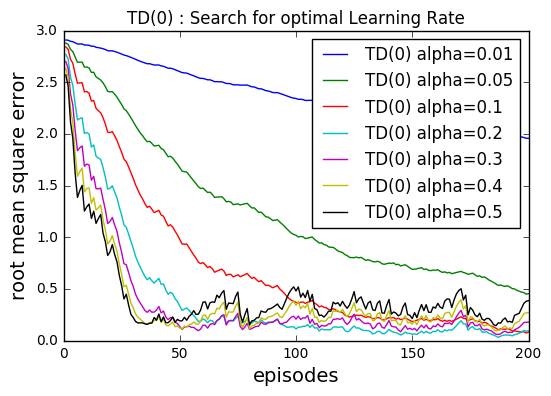

In [234]:
avg_rmse_all = np.zeros((n_episodes, len(alphas)))
for i in range(len(alphas)):
    state_value = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)
    alpha = alphas[i]
    state_value, rmse_all_runs = TD0_evaluate(n_episodes, n_runs, alpha)
    avg_rmse = np.mean(rmse_all_runs, axis=1)
    avg_rmse_all[:, i] = avg_rmse
    plt.plot(np.arange(n_episodes) + 1, avg_rmse_all[:,i], label='TD(0) alpha=' + str(alpha))    

plt.xlabel('episodes', fontsize=14)
plt.ylabel('root mean square error', fontsize=14)
plt.legend(loc='upper right')
plt.title('TD(0) : Search for optimal Learning Rate')
plt.show()

In [228]:
def firstVisitMC_evaluate(n_episodes, n_itr, alpha):
    episodes_state = all_episodes_state[:n_episodes]
    episodes_reward = all_episodes_reward[:n_episodes]
    
    #visited = np.zeros((27))
    #count = np.zeros((27))
    rmse_per_episode = np.zeros((n_episodes, n_itr))
    

    for k in range(n_itr):
        avg_returns = dict.fromkeys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                             '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                             '20', '21', '22', '23', '24', '25', '26'], 0)
        
        count = np.zeros((27))
        for i in range(n_episodes):
            visited = np.zeros((27))
            #count = np.zeros((27))
            for j in range(len(episodes_state[i])):
                s = episodes_state[i][j]
                #count[int(s)] += 1
                mc_return = 0
                if visited[int(s)] == 0:
                    #mc_return = sum(episodes_reward[i][j:])
                    for disc, im_reward in enumerate(all_episodes_reward[i][j:],0):
                        mc_return += (GAMMA)**disc*im_reward
                    count[int(s)] += 1
                    #avg_returns[s] = avg_returns[s] + (mc_return - avg_returns[s])/count[int(s)]
                    avg_returns[s] = avg_returns[s] + (mc_return - avg_returns[s])*alpha
                    visited[int(s)] = 1
                
            #rmse
                rmse_per_episode[i,k] = rmse(avg_returns, actual_state_value)
    #print avg_returns    
    return rmse_per_episode

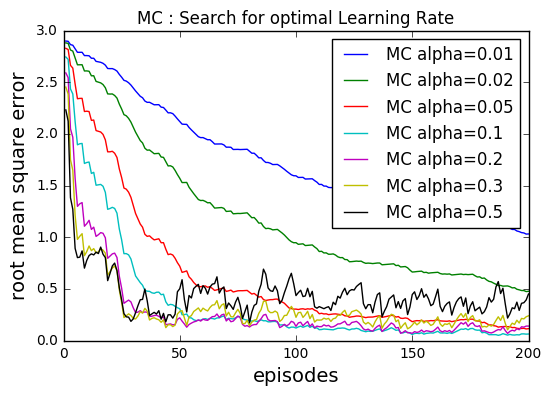

In [235]:
alphas_mc = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
avg_rmse_all_mc = np.zeros((n_episodes, len(alphas_mc)))
for i in range(len(alphas_mc)):
    alpha = alphas_mc[i]
    rmse_all_runs_mc = firstVisitMC_evaluate(n_episodes, n_runs, alpha)
    avg_rmse_mc = np.mean(rmse_all_runs_mc, axis=1)
    avg_rmse_all_mc[:, i] = avg_rmse_mc
    plt.plot(np.arange(n_episodes) + 1, avg_rmse_all_mc[:,i], label='MC alpha=' + str(alpha))    

plt.xlabel('episodes', fontsize=14)
plt.ylabel('root mean square error', fontsize=14)
plt.legend(loc='upper right')
plt.title('MC : Search for optimal Learning Rate')
plt.show()

**Comparison**

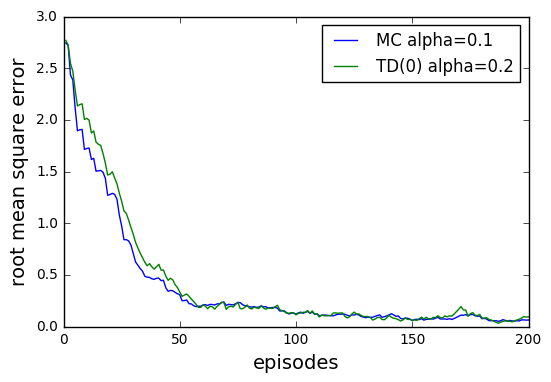

In [233]:
i = 3
plt.plot(np.arange(n_episodes) + 1, avg_rmse_all_mc[:,i], label='MC alpha=' + str(alphas_mc[i])) 

i = 3
plt.plot(np.arange(n_episodes) + 1, avg_rmse_all[:,i], label='TD(0) alpha=' + str(alphas[i]))


plt.xlabel('episodes', fontsize=14)
plt.ylabel('root mean square error', fontsize=14)
plt.legend(loc='upper right')
plt.show()

**Discussion :**

Though TD methods have usually been found to converge faster than constant-$\alpha$ MC methods on stochastic tasks, in this environment MC performs as good as TD(0). The same comparison has been done on GridWorld domain where TD(0) outperformed MC.